### Exercise 1

1. Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

<ipython-input-64-524583f2d7d7>:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  sk.io.imshow(image)


Grayscale image (1 channel)
Image shape: (303, 384)
Grayscale pixel range: 1 to 252


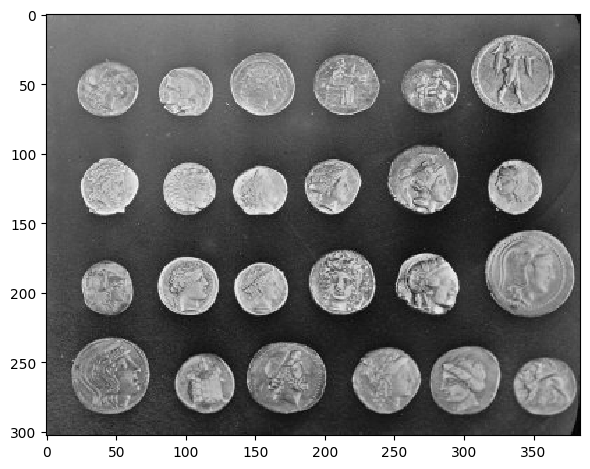

In [64]:
import skimage as sk
from skimage.io import imread
import numpy as np
image = sk.data.coins()
sk.io.imshow(image)

# Find whether the image is grayscale or RGB by the number of channels it has
if image.ndim == 2:
    print("Grayscale image (1 channel)")
    num_channels = 1
elif image.ndim == 3:
    num_channels = image.shape[2]
    print(f"Color image with {num_channels} channels")
else:
    print("Unexpected image format")

image_shape = image.shape
min_pixel = np.min(image)
max_pixel = np.max(image)

print(f"Image shape: {image_shape}")
print(f"Grayscale pixel range: {min_pixel} to {max_pixel}")

### Exercise 2

2. Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

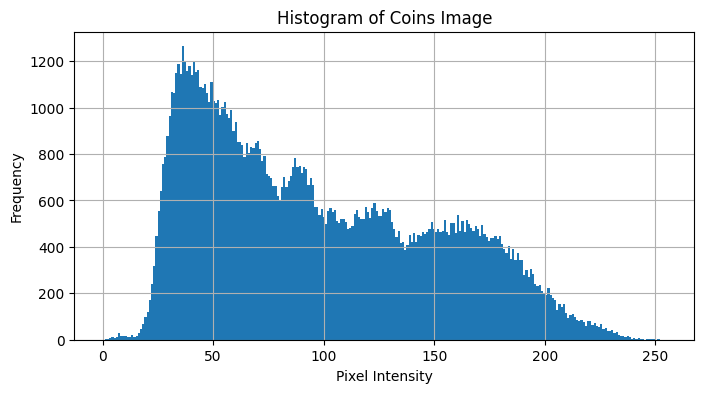

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.hist(image.ravel(), bins=256, range=(0, 255))
plt.title('Histogram of Coins Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The histogram counts how many pixels fall into each intensity value (0–255), (0-252) in this case. Left peaks represent dark values:
the background, shadows, or space between coins. The right peaks represent the brighter values: the coin surfaces, especially the metallic shine.

### Exercise 3

3. Applied noise to the image and use the correct function to erase the noise.

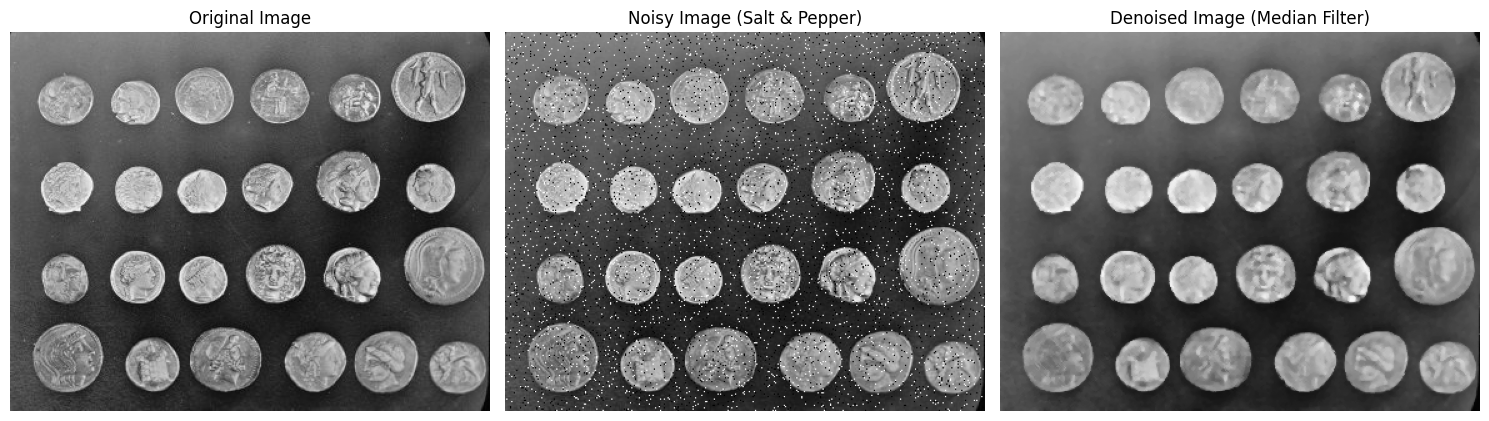

In [66]:
# Apply noise (Salt & Pepper)
noisy_image = sk.util.random_noise(image, mode='s&p')

# Convert to 8-bit grayscale
noisy_image_8bit = (noisy_image * 255).astype('uint8')

# Denoise using median filter
from skimage.filters import median
from skimage.morphology import disk

denoised_image = median(noisy_image_8bit, disk(2))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray')
axes[1].set_title('Noisy Image (Salt & Pepper)')
axes[1].axis('off')

axes[2].imshow(denoised_image, cmap='gray')
axes[2].set_title('Denoised Image (Median Filter)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Exercise 4

4. Segment the image using a k-means clustering algorithm with k=2 and represent the result

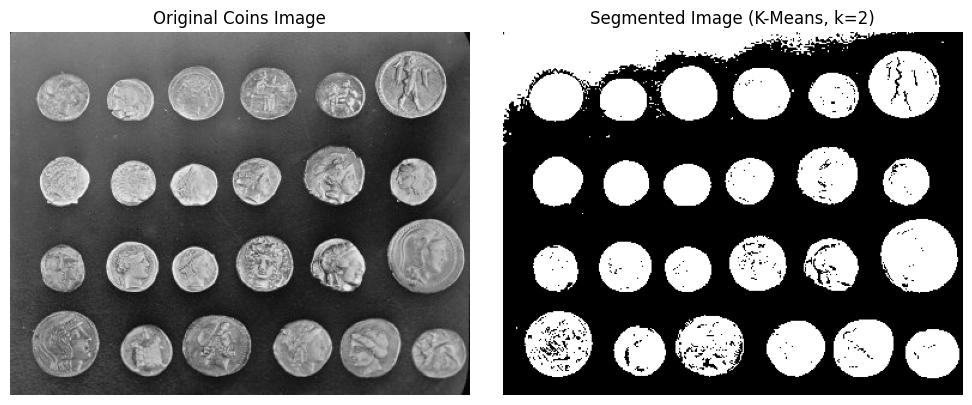

In [67]:
from sklearn.cluster import KMeans

# Flatten the image for clustering
pixels = image.reshape(-1, 1)

# Apply K-Means with k=2
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(pixels)

# Reshape labels back to image dimensions
segmented = kmeans.labels_.reshape(image.shape)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Coins Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image (K-Means, k=2)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Exercise 5

5. Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

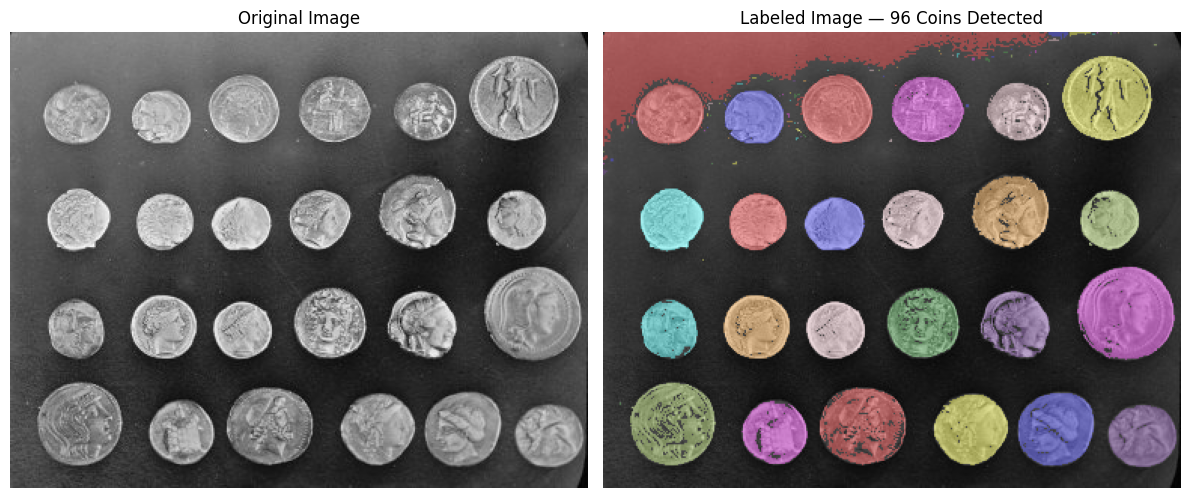

In [68]:
# Threshold using Otsu's method
threshold = sk.filters.threshold_otsu(image)
binary = image > threshold

# Label connected components
label_image = sk.measure.label(binary)

# Overlay labels on original image
overlay = sk.color.label2rgb(label_image, image=image, bg_label=0)

# Count number of labeled regions (excluding background label 0)
num_coins = np.max(label_image)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(overlay)
axes[1].set_title(f'Labeled Image — {num_coins} Coins Detected')
axes[1].axis('off')

plt.tight_layout()
plt.show()

As the number of coins is actually much smaller than 96, I will remove the spourious regions

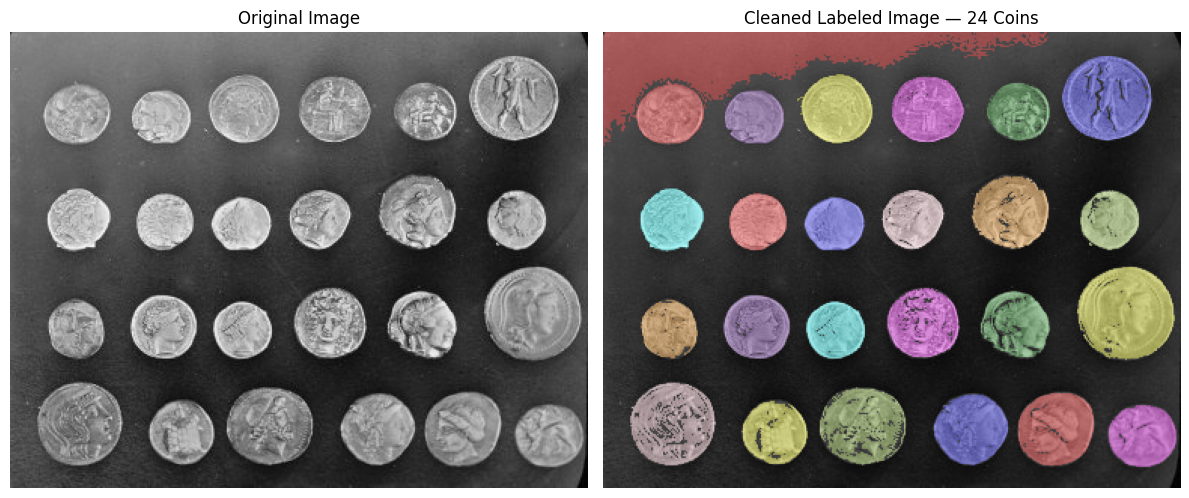

In [71]:
# Measure region properties to identify small areas
regions = sk.measure.regionprops(label_image)

# Identify indices of small regions
small_region_indices = [r.label for r in regions if r.area < 500]

# Set small regions to 0 (remove them)
for i in small_region_indices:
    label_image[label_image == i] = 0  # Re-label as background


# Overlay labels on this newly obtained image
overlay = sk.color.label2rgb(label_image, image=image)

# Count remaining labeled regions
num_remaining = np.max(label_image)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(overlay)
axes[1].set_title(f'Cleaned Labeled Image — {num_remaining} Coins')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Exercise 6

6. Extract the area, major axis length and orientation of each coin. Report the average values of the extracted features. Represent a scatterplot of the area vs major axis length.

In [72]:
import pandas as pd

# Extract region properties into a DataFrame
properties = ['label', 'area', 'major_axis_length', 'eccentricity']
props = sk.measure.regionprops_table(label_image, properties=properties)

df_features = pd.DataFrame(props)
df_features.head()

,label,area,major_axis_length,eccentricity
0,1,8792.0,292.106573,0.975705
1,2,2459.0,59.966495,0.329384
2,3,1687.0,47.569623,0.308543
3,4,1631.0,47.608317,0.386946
4,5,1194.0,41.353879,0.394435


In [73]:
# The average values of the extracted features
print(f"Average Area: {df_features['area'].mean():.2f}")
print(f"Average Major Axis Length: {df_features['major_axis_length'].mean():.2f}")
print(f"Average Eccentricity (Orientation): {df_features['eccentricity'].mean():.2f}")

Average Area: 1870.58
Average Major Axis Length: 57.02
Average Eccentricity (Orientation): 0.38


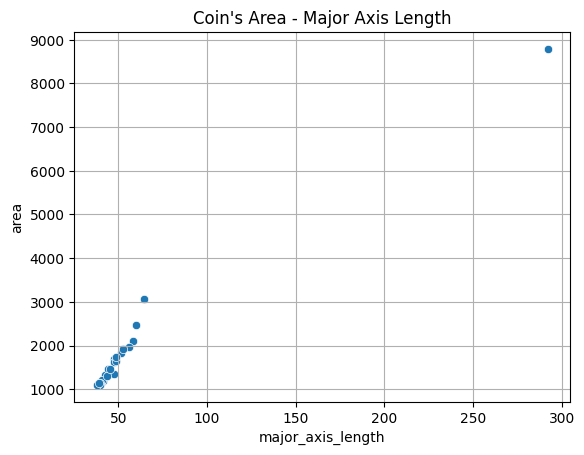

In [74]:
# Represent area of the coins as a function of the major axis length

import seaborn as sns

sns.scatterplot(x='major_axis_length',y='area',data=df_features)
plt.title('Coin\'s Area - Major Axis Length')
plt.grid('true')

## Exercise 7

7. Using the labeled regions from the 'coins' image, how can I filter the regions to find those with an area greater than 1750 pixels, count how many such coins there are?

In [75]:
# Find which coins have an area greater then 1750 pixels

df_features.loc[df_features['area']>1750]

,label,area,major_axis_length,eccentricity
0,1,8792.0,292.106573,0.975705
1,2,2459.0,59.966495,0.329384
6,7,1836.0,51.388453,0.373529
12,13,3062.0,64.327036,0.305875
18,19,2111.0,58.136960,0.244439
19,20,1971.0,56.055225,0.419267
20,21,1918.0,52.847912,0.427326


In [76]:
# Count the number of these coins

df_large_coins = df_features.loc[df_features['area']>1750]
N_large = df_large_coins.shape[0]
print('there are {} coins with an area larger than 1750 pixels'.format(N_large))

there are 7 coins with an area larger than 1750 pixels


## Exercise 8

8. Generate a 3-panel figure with the original image, the image with the little coins < 1750 coins (red color) and an image with the big coins > 1750 (blue color).

In [77]:
# Find which coins have an area smaller then 1750 pixels

df_features.loc[df_features['area']<1750]

,label,area,major_axis_length,eccentricity
2,3,1687.0,47.569623,0.308543
3,4,1631.0,47.608317,0.386946
4,5,1194.0,41.353879,0.394435
5,6,1135.0,40.092938,0.432312
7,8,1325.0,42.451724,0.341981
8,9,1203.0,40.921169,0.378973
9,10,1137.0,39.868831,0.343511
10,11,1129.0,39.179294,0.347995
11,12,1104.0,39.634983,0.444839
13,14,1634.0,48.451550,0.301131


In [78]:
# Count the number of these coins

df_small_coins = df_features.loc[df_features['area']<1750]
N_small = df_small_coins.shape[0]
print('there are {} coins with an area smaller than 1750 pixels'.format(N_small))

there are 17 coins with an area smaller than 1750 pixels


In [79]:
# Find the labels of small and large coins

labels_small = df_small_coins['label'].values
print('labels of small blobs: {}'.format(labels_small))
labels_large = df_large_coins['label'].values
print('labels of large blobs: {}'.format(labels_large))

labels of small blobs: [ 3  4  5  6  8  9 10 11 12 14 15 16 17 18 22 23 24]
labels of large blobs: [ 1  2  7 13 19 20 21]


In [80]:
# Create a binary mask with the large and small coins

mask_small_coins = np.isin(label_image, labels_small)
mask_large_coins = np.isin(label_image, labels_large)

In [81]:
# Create RGB masks

colored_small = np.zeros((*image.shape, 3), dtype=np.uint8)
colored_small[mask_small_coins] = [255, 0, 0]  # Red

colored_large = np.zeros((*image.shape, 3), dtype=np.uint8)
colored_large[mask_large_coins] = [0, 0, 255]  # Blue

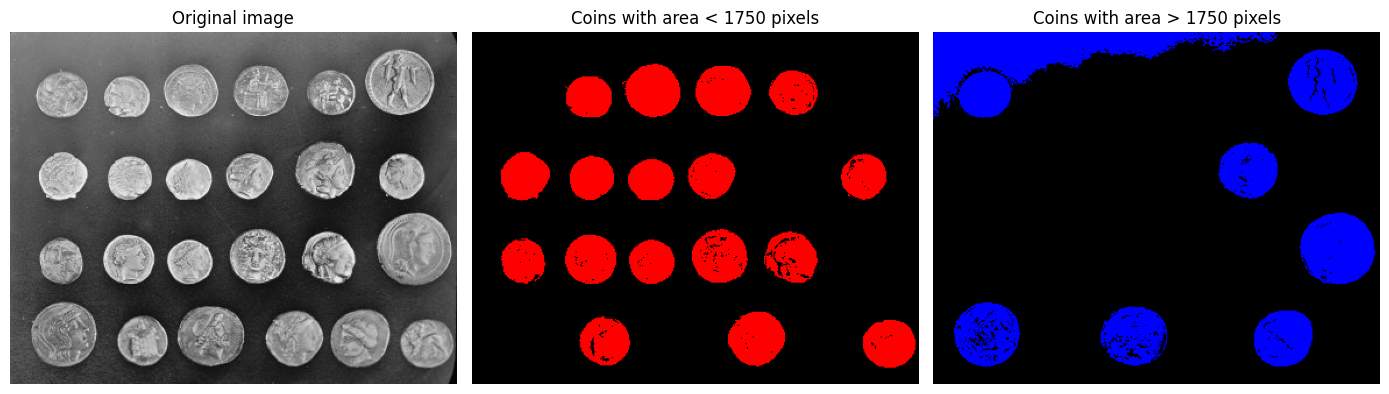

In [82]:
# Represent the large and small coins

fig, axes = plt.subplots(1, 3, figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')

ax[1].imshow(colored_small)
ax[1].set_title('Coins with area < 1750 pixels')

ax[2].imshow(colored_large)
ax[2].set_title('Coins with area > 1750 pixels')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

## Exercise 9

9. Describe the main steps required to perform segmentation of an RGB image using an unsupervised clustering algorithm (use other algorithms different than K-Means and compare the results)

I will be using **Gaussian Mixture Models (GMM)** to perform segmentation of an image. The steps required to achieve this:

1. Preprocess the image (Convert RGB image to a suitable format for clustering (vectorized)

2. Build a feature space (Use color channels (R, G, B) and optionally pixel coordinates (x, y) to improve spatial coherence)

3. Apply GMM (Fit a Gaussian Mixture Model using sklearn.mixture.GaussianMixture)

4. Reshape predictions (Reshape the predicted cluster labels back to image dimensions)

5. Visualize segmented regions (Assign cluster IDs to display each region with a distinct color)


To compare with the results obtained in question 4.

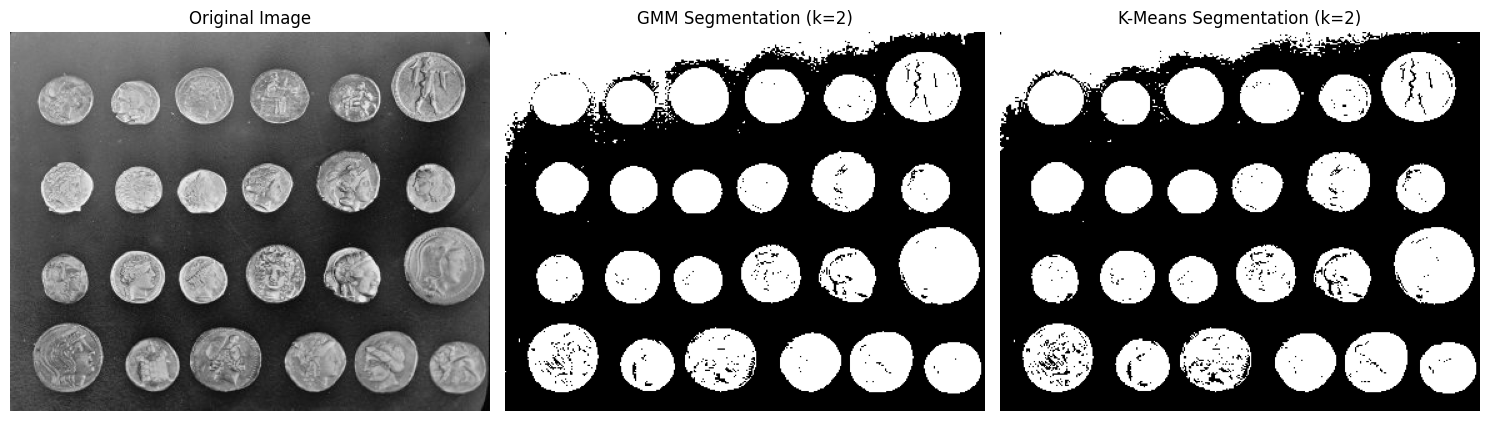

In [83]:
from sklearn.mixture import GaussianMixture

height, width = image.shape

# 2. Flatten for clustering
pixels = image.reshape(-1, 1)

# 3. GMM Segmentation (unsupervised)
gmm = GaussianMixture(n_components=2, random_state=0)
gmm_labels = gmm.fit_predict(pixels)
gmm_segmented = gmm_labels.reshape(height, width)

# 5. Visual Comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(gmm_segmented, cmap='gray')
axes[1].set_title('GMM Segmentation (k=2)')
axes[1].axis('off')

axes[2].imshow(segmented, cmap='gray')
axes[2].set_title('K-Means Segmentation (k=2)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

**Results**

While both methods produced binary segmentation, GMM allowed for smoother transitions and better separation of coin regions with varying intensities.

GMM:  
- Stronger boundary precision around coins.
- Many internal details on the coin faces are well preserved (especially shadows and textural info).
- Handles illumination changes and gradients better.

K-Means:
- Captures the overall shape of the coins quite well.
- Some coins show more textural noise inside.
- Sharper but less adaptive, struggles with smooth grayscale transitions.
- Background has slightly more noise than GMM.

GMM outperforms K-Means when handling smooth gradients, coin textures, and shadowed regions. However, as discussed also in class, GMM is slower and more computationally expensive.

## Exercise 10

10. Extract the main texture features of this image

In [87]:
from skimage.feature.texture import graycomatrix, graycoprops

props = sk.measure.regionprops(label_image, intensity_image=image)

nregions = len(props)
props_texture = np.zeros((nregions, 5))

for iregion, p in enumerate(props):
    minr, minc, maxr, maxc = p.bbox
    I = image[minr:maxr, minc:maxc]

    if I.size == 0 or np.all(I == I[0, 0]):
        continue

    g = graycomatrix(I, [1], [0], levels=256, normed=True, symmetric=True)

    props_texture[iregion, 0] = graycoprops(g, 'contrast')[0, 0]
    props_texture[iregion, 1] = graycoprops(g, 'dissimilarity')[0, 0]
    props_texture[iregion, 2] = graycoprops(g, 'homogeneity')[0, 0]
    props_texture[iregion, 3] = graycoprops(g, 'energy')[0, 0]
    props_texture[iregion, 4] = graycoprops(g, 'correlation')[0, 0]

# Create DataFrame and export to Excel
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("Texture_features.xlsx", index=False)
df

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,254.474130,7.573417,0.310996,0.033827,0.890400
1,995.526634,21.321429,0.086937,0.017297,0.765693
2,529.480035,13.988465,0.120241,0.023318,0.815702
3,577.133102,16.666007,0.083029,0.020208,0.784722
4,1028.797176,21.617458,0.076587,0.021379,0.736437
5,595.839560,15.282784,0.098988,0.025766,0.798615
6,891.572083,19.571250,0.075520,0.018196,0.845380
7,784.764808,17.322300,0.097732,0.022090,0.857712
8,1067.844278,20.778612,0.072951,0.021424,0.832012
9,948.079605,18.903289,0.085836,0.023050,0.873162


## Personal Discussion

**Provide a thoughtful reflection on the Computer Vision course, including your perspective on the knowledge you have acquired and your opinion about the professor. (Thank you very much for your feedback!)**




Taking the Computer Vision course has been a deeply rewarding and enriching experience. I’ve developed a solid understanding of fundamental techniques that are not only academically relevant, and will be very useful in the courses that I will follow in the next semesters of my Master's degree, but also highly applicable in real-world computer vision tasks.

I particularly appreciated the hands-on, practical structure of the course.Working with real image data, implementing filters, applying clustering algorithms, and analyzing texture features gave me a clear picture of how computer vision is used in practice.

In terms of instruction, I found Professor Christian to be an excellent and passionate educator. His teaching was clear, structured, and practical, with a strong emphasis on understanding the why behind each method, not just the how. The exercises were thoughtfully designed to build confidence gradually, and his responsiveness and availability during the sessions made a big difference.

Overall, I enjoyed the course so much and learned a lot! I can wholeheartedly say that the course and the professor were one of the best and most memorable throughout my academic journey!

Thank you for continuing to teach to us, Professor, even in days that haven't been easy for you!